<a href="https://colab.research.google.com/github/timegrocery/botbla/blob/master/3118410235.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploratory Analysis
Import các thư viện cần thiết cho việc khai phá dữ liệu

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import plotly.graph_objs as go
import numpy as np # linear algebra
import os # accessing directory structure
import plotly.express as px
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
import plotly as py


Hiển thị tập dữ liệu


In [ ]:
for dirname, _, filenames in os.walk('/content/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/input/heart.csv


Định nghĩa các hàm sẽ sử dụng sau:

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Số lượng')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (Cột {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('Cột') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Ma trận tương quan của {filename}', fontsize=15)
    plt.show()


In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 15: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:15]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Biểu đồ phân tán và mật độ')
    plt.show()


### Kiểm tra file: /input/heart.csv


In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# heart.csv has 1025 rows in reality, but we are only loading/previewing the first 1000 rows
df = pd.read_csv('/content/input/heart.csv', delimiter=',', nrows = nRowsRead)
df.dataframeName = 'heart.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 14 columns


Nội dung của tập dữ liệu đã import:

In [ ]:
#df1.head()
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
996,56,0,0,134,409,0,0,150,1,1.9,1,2,3,0
997,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0
998,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0


Tổng số dòng và cột:

In [ ]:
df.shape

(1000, 14)

Thông tin tổng quan về tập dữ liệu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1000 non-null   int64  
 1   sex       1000 non-null   int64  
 2   cp        1000 non-null   int64  
 3   trestbps  1000 non-null   int64  
 4   chol      1000 non-null   int64  
 5   fbs       1000 non-null   int64  
 6   restecg   1000 non-null   int64  
 7   thalach   1000 non-null   int64  
 8   exang     1000 non-null   int64  
 9   oldpeak   1000 non-null   float64
 10  slope     1000 non-null   int64  
 11  ca        1000 non-null   int64  
 12  thal      1000 non-null   int64  
 13  target    1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB


Đếm số hàng bị rỗng trong dataset

In [ ]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Tóm tắt thống kê của tập dữ liệu, bao gồm giá trị trung bình, số hàng, độ lệch tiêu chuẩn, phân vị, giá trị min và max của từng cột

In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,54.489000,0.692000,0.950000,131.781000,246.185000,0.15000,0.528000,149.089000,0.337000,1.072200,1.384000,0.753000,2.323000,0.515000
std,9.101248,0.461898,1.029835,17.574638,51.710916,0.35725,0.524873,23.027969,0.472921,1.176321,0.617191,1.031045,0.620529,0.500025
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.00000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,0.00000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,0.00000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Dạng dữ liệu

In [ ]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Biểu đồ phân bố dữ liệu theo trường 'sex'

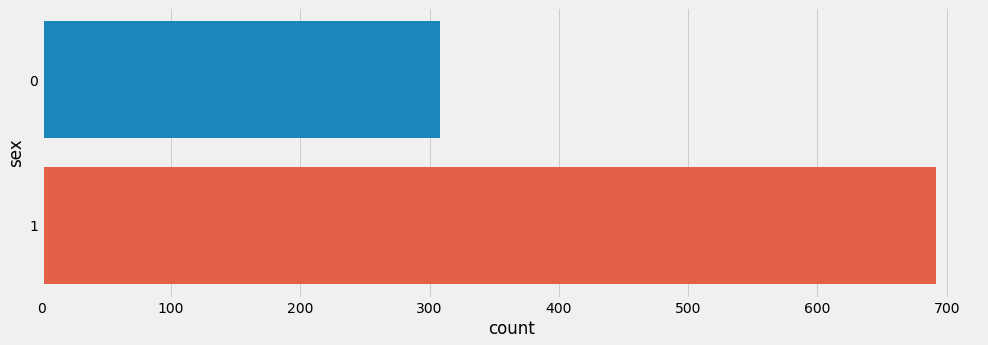

In [ ]:
X = df.iloc[:, [2,3]].values
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'sex' , data = df)
plt.show()

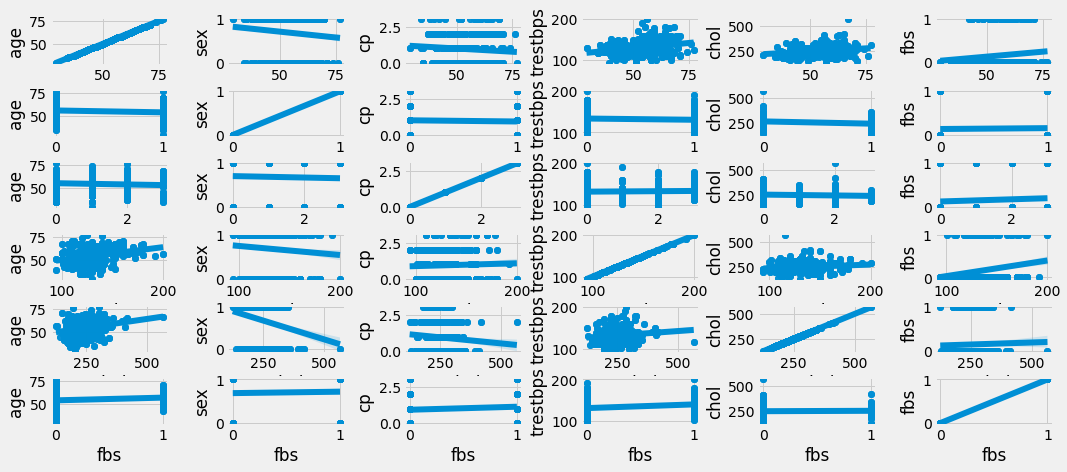

In [ ]:
plt.figure(1 , figsize = (16 , 7))
n = 0 
for x in ['age' , 'sex' , 'cp', 'trestbps', 'chol', 'fbs']:
    for y in ['age' , 'sex' , 'cp', 'trestbps', 'chol', 'fbs']:
        n += 1
        plt.subplot(6 , 6 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

Dùng Elbow method để chọn số cluster hợp lý

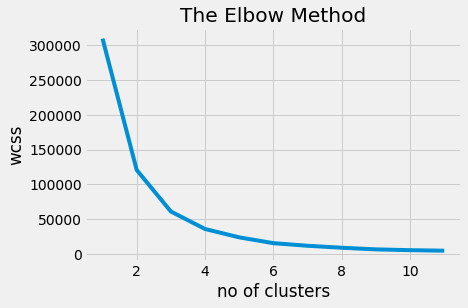

In [ ]:
# Chọn số cụm  Elbow Method
wcss=[]
for i in range(1,12):
    #n_clusters: the number of centroids to generate.
    #init:  selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
    #random_state:
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    centers = kmeans.cluster_centers_

plt.plot(range(1,12), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

**Sự thay đổi theo độ tuổi của lượng cholestoral trong huyết thanh, huyết áp lúc nghỉ ngơi và nhịp tim tối đa**





In [ ]:
df.plot(
    kind='scatter',
    x='age', 
    y=['chol', 'trestbps', 'thalach'], 
    backend='plotly', 
    width=500,   
)

Biểu đồ phân bố dữ liệu

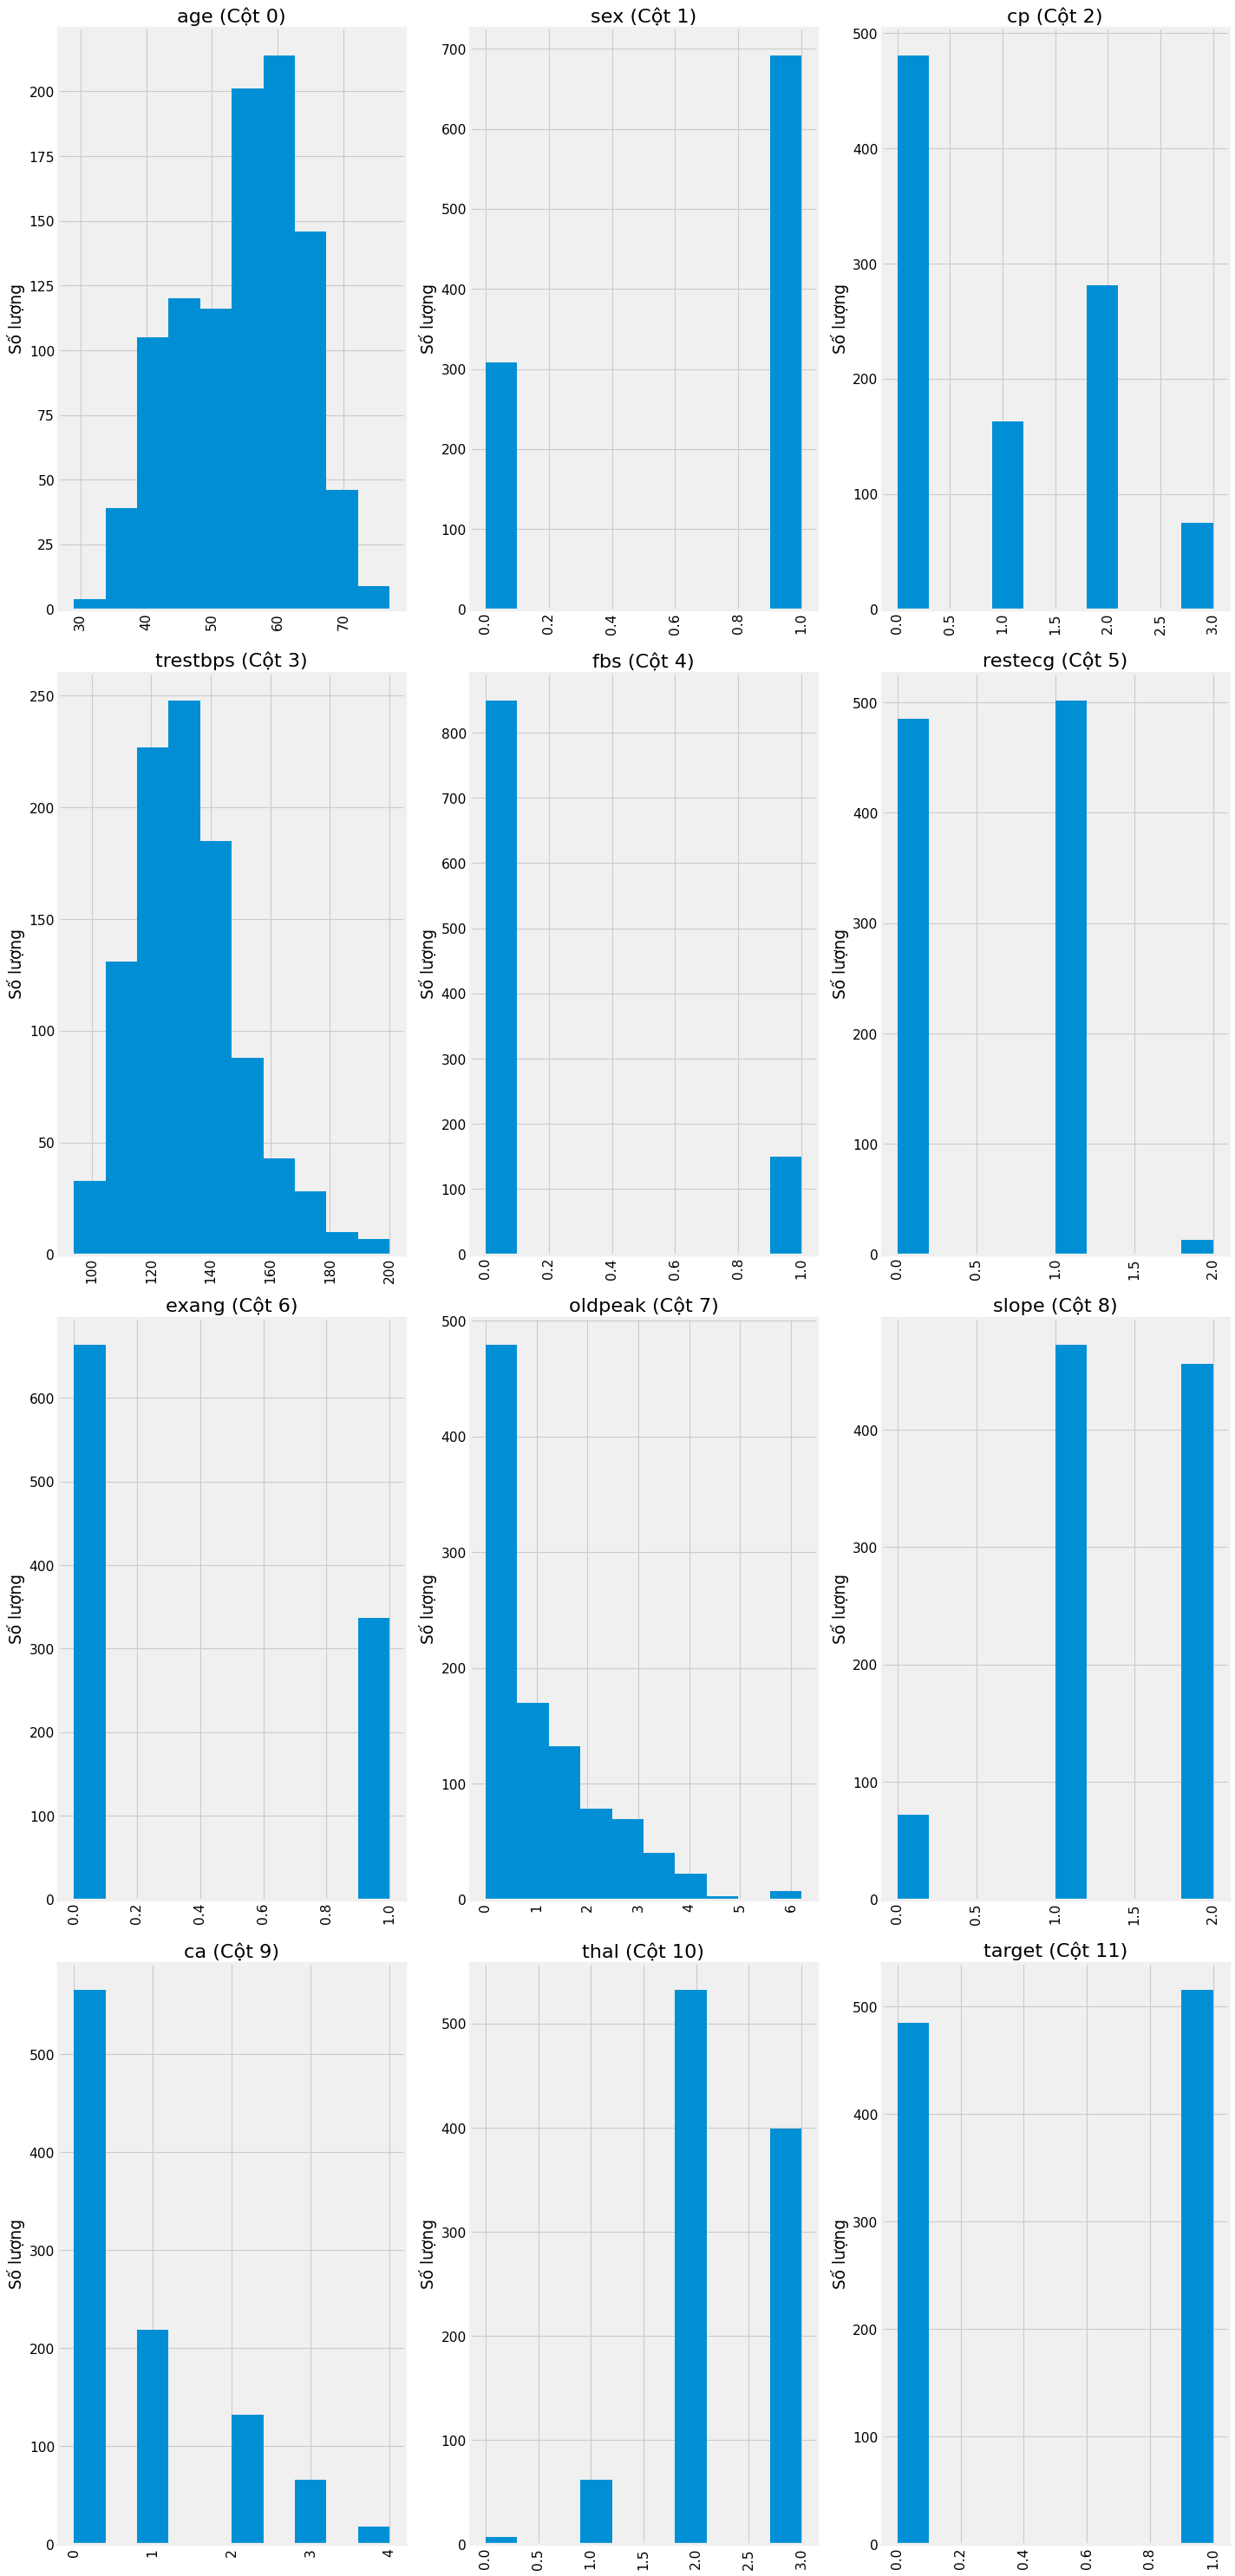

In [ ]:
plotPerColumnDistribution(df, 14, 3)

Ma trận tương quan:

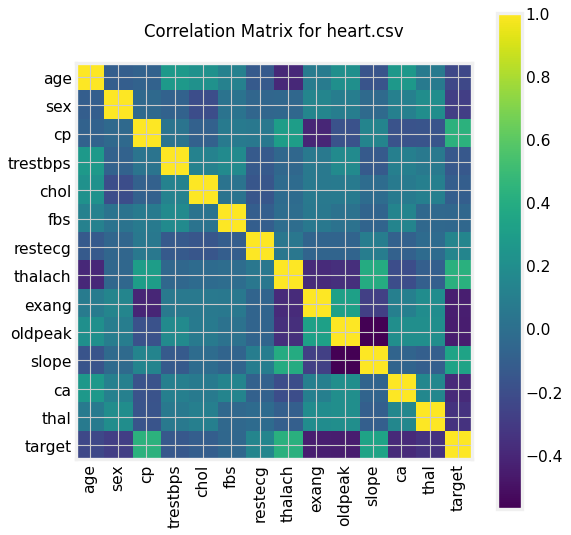

In [ ]:
plotCorrelationMatrix(df, 8)

Scatter and density plots:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


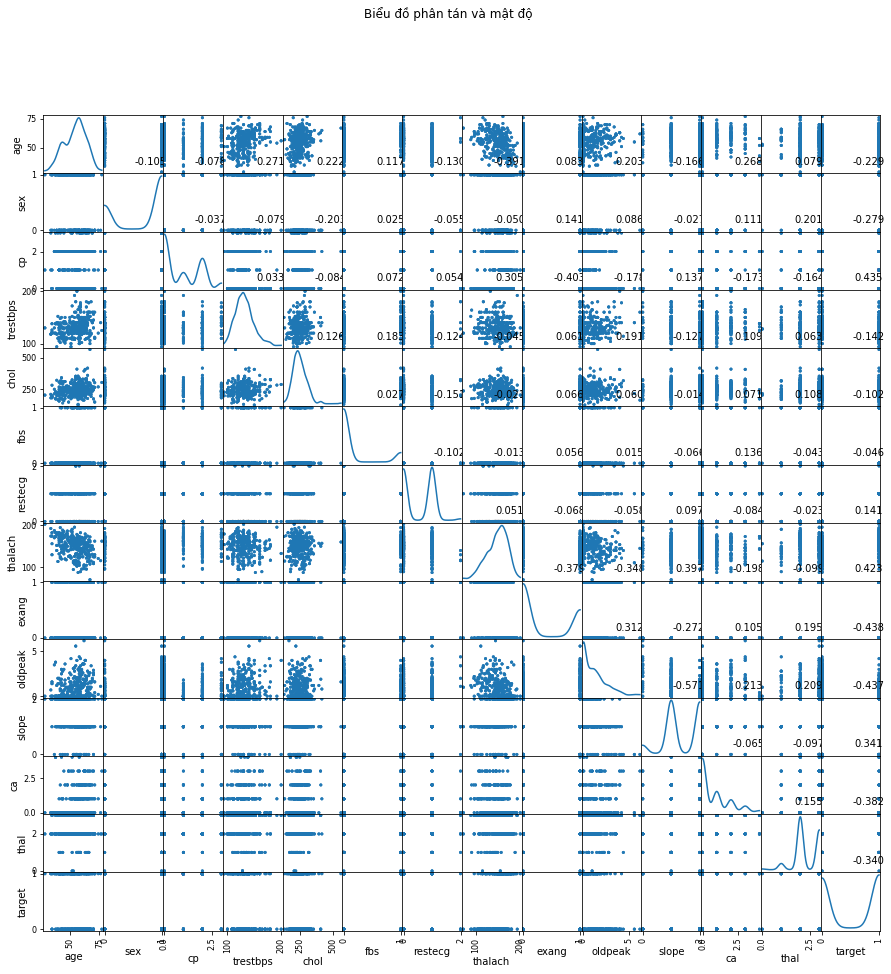

In [ ]:
plotScatterMatrix(df, 15, 10)

Loại bỏ cảnh báo

In [ ]:
import warnings

warnings.filterwarnings('ignore')

Khai báo vector và biến mục tiêu

In [ ]:
X = df

y = df['target']

Chuyển đổi các biến thành số nguyên

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['oldpeak'] = le.fit_transform(X['oldpeak'])

y = le.transform(y)

Xem tóm tắt vector X

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       1000 non-null   int64
 1   sex       1000 non-null   int64
 2   cp        1000 non-null   int64
 3   trestbps  1000 non-null   int64
 4   chol      1000 non-null   int64
 5   fbs       1000 non-null   int64
 6   restecg   1000 non-null   int64
 7   thalach   1000 non-null   int64
 8   exang     1000 non-null   int64
 9   oldpeak   1000 non-null   int64
 10  slope     1000 non-null   int64
 11  ca        1000 non-null   int64
 12  thal      1000 non-null   int64
 13  target    1000 non-null   int64
dtypes: int64(14)
memory usage: 109.5 KB


Tổng quan tập dữ liệu X

In [ ]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,10,2,2,3,0
1,53,1,0,140,203,1,0,155,1,29,0,0,3,0
2,70,1,0,145,174,0,1,125,1,25,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,18,1,3,2,0


Quy mô tính năng

In [ ]:
cols = X.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()

X = ms.fit_transform(X)

In [ ]:
X = pd.DataFrame(X, columns=[cols])

In [ ]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.479167,1.0,0.0,0.292453,0.196347,0.0,0.5,0.740458,0.0,0.256410,1.0,0.50,1.000000,0.0
1,0.500000,1.0,0.0,0.433962,0.175799,1.0,0.0,0.641221,1.0,0.743590,0.0,0.00,1.000000,0.0
2,0.854167,1.0,0.0,0.481132,0.109589,0.0,0.5,0.412214,1.0,0.641026,0.0,0.00,1.000000,0.0
3,0.666667,1.0,0.0,0.509434,0.175799,0.0,0.5,0.687023,0.0,0.000000,1.0,0.25,1.000000,0.0
4,0.687500,0.0,0.0,0.415094,0.383562,1.0,0.5,0.267176,0.0,0.461538,0.5,0.75,0.666667,0.0


Tạo mô hình K-means với 5 cluster

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0) 

kmeans.fit(X)
KMeans(algorithm='auto', copy_x=True, init='k-means++', n_clusters=5, random_state=0, tol=0.0001, verbose=0)

KMeans(n_clusters=5, random_state=0)

Tọa độ các cluster tìm được



In [ ]:
kmeans.cluster_centers_

array([[ 5.57452276e-01,  1.00000000e+00,  6.31424376e-02,
         3.47643587e-01,  2.78357774e-01,  1.67400881e-01,
         2.11453744e-01,  4.59528533e-01,  1.00000000e+00,
         4.36462216e-01,  5.39647577e-01,  2.76431718e-01,
         8.51688693e-01,  3.96475771e-02],
       [ 5.35687593e-01,  1.11022302e-15,  4.40956652e-01,
         3.29850241e-01,  2.96639843e-01,  8.52017937e-02,
         2.95964126e-01,  6.33553555e-01,  1.07623318e-01,
         1.41428079e-01,  7.89237668e-01,  7.51121076e-02,
         6.66666667e-01,  1.00000000e+00],
       [ 4.50161955e-01,  1.00000000e+00,  4.92343934e-01,
         3.41022735e-01,  2.37305775e-01,  1.76678445e-01,
         3.02120141e-01,  7.03422976e-01,  1.30742049e-01,
         1.38171605e-01,  8.07420495e-01,  1.06890459e-01,
         7.38515901e-01,  1.00000000e+00],
       [ 5.73145604e-01,  1.00000000e+00,  3.27838828e-01,
         3.58127721e-01,  2.66395705e-01,  1.09890110e-01,
         2.33516484e-01,  5.77174734e-01,  1.

**Quán tính:**
Quán tính của mô hình càng thấp thì mô hình càng chính xác. Ta có thể thấy quán tính của mô hình này là 683.* là khá cao. Do đó đây không phải là một mô hình phù hợp cho dữ liệu.

In [ ]:
kmeans.inertia_

683.6867038870367

In [ ]:
from sklearn.cluster import KMeans

clusters = 5
kmeans = KMeans(n_clusters=clusters,random_state=0)

kmeans.fit(X)
print("Model's inertia:")
kmeans.inertia_

Model's inertia:


683.6867038870367